In [30]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import tensorflow as tf

models = tf.keras.models  # like from tensorflow.keras import models (PyCharm import issue workaround)
layers = tf.keras.layers  # like from tensorflow.keras import layers (PyCharm import issue workaround)


def load_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    train_images = train_images.reshape((60000, 28, 28, 1))
    test_images = test_images.reshape((10000, 28, 28, 1))

    # Normalize pixel values to be between 0 and 1
    train_images, test_images = train_images / 255.0, test_images / 255.0

    return train_images, train_labels, test_images, test_labels


def display_images(train_data, train_labels):
    train_data = tf.reshape(train_data, [60000, 28, 28])
    # Display Digits
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.tight_layout()
        plt.imshow(train_data[i], cmap='gray', interpolation='none')
        plt.title("Digit: {}".format(train_labels[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()


def build_cnn():

    # Set up model type
    model = models.Sequential()

    # Add layers, inspired by https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def train_cnn(model, train_images, train_labels):
    model.fit(train_images, train_labels, epochs=2, batch_size=5000)
    return model


def evaluate_cnn(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    return test_loss, test_acc


def plot_accuracy(model):
    # Plot training & validation accuracy values
    try:
        plt.plot(model.history.history['accuracy'])
    except KeyError:
        plt.plot(model.history.history['acc'])
#     plt.plot(model.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def plot_loss(model):
    # Plot training & validation loss values
    plt.plot(model.history.history['loss'])
#     plt.plot(model.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [4]:
# Load data
train_images, train_labels, test_images, test_labels = load_data()

# Train model
model = build_cnn()
model = train_cnn(model, train_images, train_labels)

# Evaluate model
test_loss, test_acc = evaluate_cnn(model, test_images, test_labels)
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/2
60000/60000 [==============================] - 24s 399us/sample - loss: 2.0100 - acc: 0.5363
Epoch 2/2
10000/10000 [==============================] - 1s 108us/sample - loss: 0.4803 - acc: 0.8530
Test Accuracy:  0.853
Test Loss:  0.4803491915345192


In [31]:
model.history.history

{'loss': [2.009982854127884, 0.829040085275968],
 'acc': [0.5363167, 0.79618335]}

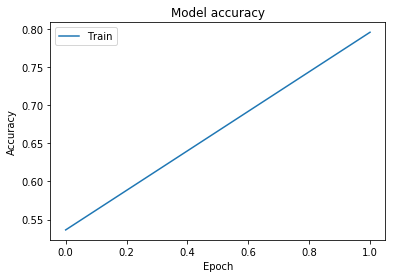

In [32]:
plot_accuracy(model)

In [25]:
test_loss, test_acc = evaluate_cnn(model, test_images, test_labels)
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

10000/10000 [==============================] - 2s 227us/sample - loss: 0.4803 - acc: 0.8530
Test Accuracy:  0.853
Test Loss:  0.4803491915345192
